In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
dataset = xr.open_dataset("../../combined_data/jan2025.nc")
dataset

<xarray.Dataset> Size: 3MB
Dimensions:     (valid_time: 744, latitude: 8, longitude: 16)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2025-01-01 ... 2025-01-31T23:...
  * latitude    (latitude) float64 64B 34.75 34.65 34.55 ... 34.25 34.15 34.05
  * longitude   (longitude) float64 128B -119.0 -118.9 -118.8 ... -117.6 -117.5
    expver      (valid_time) <U4 12kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 381kB ...
    u10         (valid_time, latitude, longitude) float32 381kB ...
    v10         (valid_time, latitude, longitude) float32 381kB ...
    tp          (valid_time, latitude, longitude) float32 381kB ...
    lai_hv      (valid_time, latitude, longitude) float32 381kB ...
    lai_lv      (valid_time, latitude, longitude) float32 381kB ...
    frp         (valid_time, latitude, longitude) float32 381kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-18T21:20 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
input_vars = ["d2m", "u10", "v10", "tp", "lai_hv", "lai_lv"]
output_vars = ["frp"]

dataset[input_vars]

<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 744, latitude: 8, longitude: 16)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2025-01-01 ... 2025-01-31T23:...
  * latitude    (latitude) float64 64B 34.75 34.65 34.55 ... 34.25 34.15 34.05
  * longitude   (longitude) float64 128B -119.0 -118.9 -118.8 ... -117.6 -117.5
    expver      (valid_time) <U4 12kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 381kB ...
    u10         (valid_time, latitude, longitude) float32 381kB ...
    v10         (valid_time, latitude, longitude) float32 381kB ...
    tp          (valid_time, latitude, longitude) float32 381kB ...
    lai_hv      (valid_time, latitude, longitude) float32 381kB ...
    lai_lv      (valid_time, latitude, longitude) float32 381kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-18T21:20 GRIB to CDM+CF via cfgrib-0.9.1...

## First Model
- No spatial or temporal considerations, just run a XGBoost model with the env vars as inputs and frp as output

In [4]:
# Convert netcdf data to tabular format
X = np.stack([dataset[input_var].values for input_var in input_vars], axis=-1)
X.shape

(744, 8, 16, 6)

In [8]:
y = dataset['frp'].values
y.shape

(744, 8, 16)

In [9]:
# Reshape into 2D arrays (samples, features)
n_samples = 744 * 8 * 16
X_reshaped = X.reshape(n_samples, 6)  # Flatten time, lat, lon
y_reshaped = y.reshape(n_samples, 1)  # Flatten FRP

# Convert to DataFrame (optional, but useful for inspection)
df = pd.DataFrame(X_reshaped, columns=input_vars)
df['frp'] = y_reshaped

# for binary classification
df['fire'] = (df['frp'] > 0).astype(int)

# Drop rows with NaN (if any)
df = df.dropna()
df

,d2m,u10,v10,tp,lai_hv,lai_lv,frp,fire
0,273.648438,0.231756,-1.319763,1.088966e-05,2.225342,2.134766,0.0,0
1,273.448242,0.079290,-1.486084,6.595787e-06,3.322021,1.886902,0.0,0
2,273.350098,-0.065119,-1.626282,5.699840e-07,3.842651,1.712708,0.0,0
3,272.795410,-0.309137,-1.762390,3.771129e-07,3.671997,1.833374,0.0,0
4,272.194336,-0.674982,-1.871704,2.370507e-07,1.952026,1.499207,0.0,0
...,...,...,...,...,...,...,...,...
95227,279.121826,1.365804,1.573914,8.951180e-07,4.834839,2.170100,0.0,0
95228,278.488525,1.173970,1.417176,9.050879e-07,4.812988,2.366328,0.0,0
95229,277.994385,1.092427,1.381470,2.388021e-06,4.875977,1.364436,0.0,0
95230,277.546143,0.996785,1.322144,4.455704e-06,4.767700,1.109553,0.0,0


In [7]:
df.to_csv("../../combined_data/jan2025.csv", index=False)

In [10]:
df['fire'].sum() / 94488 * 100

np.float64(0.44344255355177375)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df[input_vars], df['frp'], test_size=0.2, random_state=42
)

In [12]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 1453069.75
R² Score: 0.59


In [25]:
y_test = y_test.to_numpy()

In [27]:
[(y_pred[i].item(), y_test[i].item()) for i in range(15)]

[(-29.361703872680664, 0.0),
 (207.20677185058594, 0.0),
 (14.25283432006836, 0.0),
 (-1.647391438484192, 0.0),
 (251.5267791748047, 0.0),
 (-66.66802215576172, 0.0),
 (-12.977374076843262, 0.0),
 (-121.88475799560547, 0.0),
 (13.341890335083008, 0.0),
 (558.78759765625, 0.0),
 (-8.061002731323242, 0.0),
 (2.466479778289795, 0.0),
 (83.71613311767578, 0.0),
 (-34.96245574951172, 0.0),
 (50.20454788208008, 0.0)]

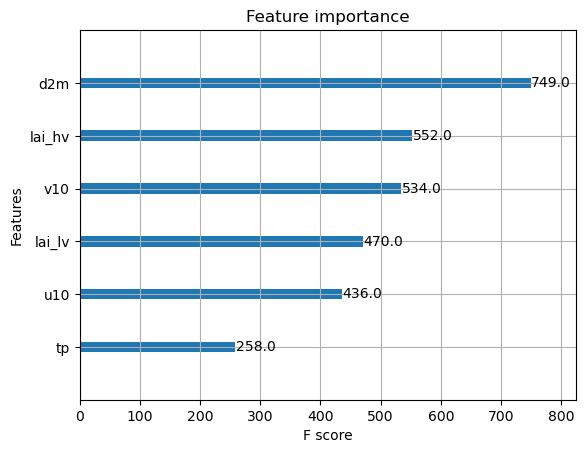

In [25]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(model)
plt.show()

With classification

In [26]:
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(df[input_vars], df['fire'], test_size=0.2, random_state=42)

# Train XGBoost classifier
clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

clf.fit(X_train, y_train)

# Evaluate classifier
y_pred_class = clf.predict(X_test)
print(classification_report(y_test, y_pred_class))
print("ROC AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18812
           1       0.86      0.42      0.56        86

    accuracy                           1.00     18898
   macro avg       0.93      0.71      0.78     18898
weighted avg       1.00      1.00      1.00     18898

ROC AUC: 0.9947917954398232


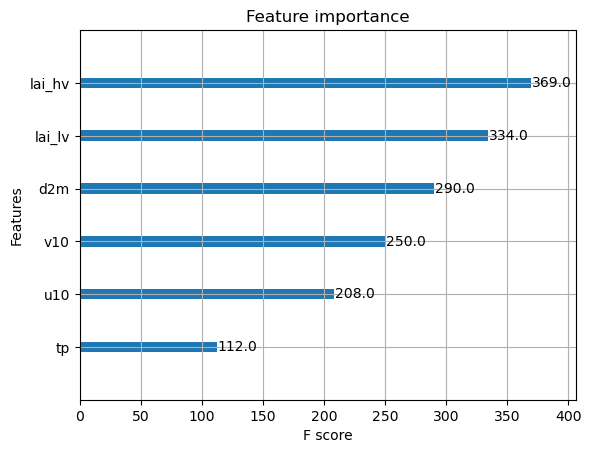

In [27]:
xgb.plot_importance(clf)
plt.show()